In [0]:
import struct
from struct import unpack
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

device = cuda


In [0]:
# Helper from: https://github.com/googlecreativelab/quickdraw-dataset/blob/master/examples/binary_file_parser.py
def unpack_drawing(file_handle, max_padding):
    # Skip key_id: 8, countrycode: 2, recognized: 1, timestamp: 4 = 15
    file_handle.read(15)
    n_strokes, = unpack('H', file_handle.read(2))
    idx = 0

    N = 0
    strokes = []
    for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      N += n_points
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      strokes.append((x, y))

    image = np.zeros((N, 3), dtype=np.float32)


    
    # Return a tensor of size number of stroke x 3 like here: https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/recurrent_quickdraw.md#optional-converting-the-data
    for i, (x, y) in enumerate(strokes):
        n_points = len(x)
        image[idx:idx+n_points, 0] = np.asarray(x)
        image[idx:idx+n_points, 1] = np.asarray(y)
        idx += n_points
        # Mark stroke end with a 1
        image[idx -1, 2] = 1


    # Preprocessing.
    # 1. Size normalization.
    lower = np.min(image[:, 0:2], axis=0)
    upper = np.max(image[:, 0:2], axis=0)
    scale = upper - lower
    scale[scale == 0] = 1
    image[:, 0:2] = (image[:, 0:2] - lower) / scale
    # 2. Compute deltas.
    image[1:, 0:2] -= image[0:-1, 0:2]
    image = image[1:, :]

    return torch.from_numpy(image[:max_padding])


def unpack_drawings(filename, max_padding):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f, max_padding)
            except struct.error:
                break

In [0]:
import urllib.request
from pathlib import Path

urllib.request.urlretrieve('https://raw.githubusercontent.com/cs-deep-quickdraw/notebooks/master/100_classes.txt', '100_classes.txt')

# Create data dir
Path("./data").mkdir(exist_ok=True)

In [0]:
f = open("100_classes.txt","r")
# And for reading use
classes = [cls.strip() for cls in f.readlines()]
f.close()

def download(classes):
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/binary/'
  for i, c in enumerate(classes):
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.bin'
    print((1+i)/len(classes), c, path)
    urllib.request.urlretrieve(path, 'data/'+c+'.bin')

In [0]:
download(classes)

0.01 drums https://storage.googleapis.com/quickdraw_dataset/full/binary/drums.bin
0.02 sun https://storage.googleapis.com/quickdraw_dataset/full/binary/sun.bin
0.03 laptop https://storage.googleapis.com/quickdraw_dataset/full/binary/laptop.bin
0.04 anvil https://storage.googleapis.com/quickdraw_dataset/full/binary/anvil.bin
0.05 baseball_bat https://storage.googleapis.com/quickdraw_dataset/full/binary/baseball%20bat.bin
0.06 ladder https://storage.googleapis.com/quickdraw_dataset/full/binary/ladder.bin
0.07 eyeglasses https://storage.googleapis.com/quickdraw_dataset/full/binary/eyeglasses.bin
0.08 grapes https://storage.googleapis.com/quickdraw_dataset/full/binary/grapes.bin
0.09 book https://storage.googleapis.com/quickdraw_dataset/full/binary/book.bin
0.1 dumbbell https://storage.googleapis.com/quickdraw_dataset/full/binary/dumbbell.bin
0.11 traffic_light https://storage.googleapis.com/quickdraw_dataset/full/binary/traffic%20light.bin
0.12 wristwatch https://storage.googleapis.com/qu

In [0]:
import os

print(len(os.listdir('data')))

100


In [0]:
class StrokeClassifier(nn.Module):
  def __init__(self, cv1, cv2, hidden_dim, n_layers, n_classes, bidirectional):
    super(StrokeClassifier, self).__init__()
    self.hidden_dim = hidden_dim

    input_size = 3

    self.bn = nn.BatchNorm1d(input_size)

    if cv1 is not None:
      self.conv1 = nn.Conv1d(input_size, cv1[0], cv1[1])
      input_size = cv1[0]

      if cv2 is not None:
        self.conv2 = nn.Conv1d(input_size, cv2[0], cv2[1])
        input_size = cv2[0]
      else:
        self.conv2 = None
    else:
      self.conv1 = None
      self.conv2 = None
    
    # The LSTM takes 3 things as input (x, y, isLastPoint) and outputs hidden states with dimensionality hidden_dim
    self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectional)

    # The linear layer maps the LSTM output to a linear space
    self.linear = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_classes)

  def forward(self, strokes):
    # BN and Convolution expect NCWH
    strokes = self.bn(strokes)
    if self.conv1 is not None:
      strokes = self.conv1(strokes)

      if self.conv2 is not None:
        strokes = self.conv2(strokes)

    # LSTM expect NHWC
    strokes = torch.transpose(strokes, 1, 2)
    out, _ = self.lstm(strokes)

    # Keep last layer of the NN
    out = out[:,-1,:]
    out = self.linear(out)
    return out

In [0]:
from torch.utils.data import Dataset

class DrawDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        assert len(self.X) == len(self.Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.X[idx], self.Y[idx])

In [0]:
# Config:
batch_size = 256
learning_rate = 0.001

hidden_size = 256
n_layers = 2
train_classes = classes[:]

# Use None instead of (n_filters, filter_size) to disable convolution
# Note that conv1 = None forces conv2 = None automatically
conv1 = (128, 3)
conv2 = None
bidirectional = True

N_train = 20000
N_val = N_train // 5
N_test = N_val
N_test_reserved = 20000
max_padding = 100
n_epochs = 10

In [0]:
from itertools import islice
from torch.nn.utils.rnn import pad_sequence

def extract_dataset(samples_train, samples_val, samples_test, test_reserved, classes, max_padding=100):
  X_train = []
  X_val = []
  X_test = []
  y_train = []
  y_val = []
  y_test = []

  for c, cls in enumerate(classes):
    drawings = unpack_drawings('data/' + cls + '.bin', max_padding)

    # TODO: itertools
    for _ in range(max(0, test_reserved - samples_train)):
      next(drawings)

    for _ in range(samples_test):
      X_test.append(next(drawings))
      y_test.append(c)

    # TODO: better way of doing this
    for _ in range(samples_train):
      X_train.append(next(drawings))
      y_train.append(c)

    for _ in range(samples_val):
      X_val.append(next(drawings))
      y_val.append(c)


  
    
    print(f"\rdone extracting class: {cls}: {1 + c} / {len(classes)}", end='')

    drawings.close()
    

  def norm(X):
    return torch.FloatTensor(torch.transpose(pad_sequence(X, batch_first=True), 1, 2))

  # XXX: instead of padding like that we could have a moving window:
  # Example if we want 100 sequences and we have an image with 200 we can use the windows:
  # 0-100, 10-110, ... 100-200 for instance, this would add data
  X_train = norm(X_train)
  X_val = norm(X_val)
  X_test = norm(X_test)
  #print("training shape", X_train.shape)
  print("validation shape", X_val.shape)
  print("testing shape", X_test.shape)
  print("classes", len(classes))

  return (
      DrawDataset(X_train, torch.LongTensor(y_train)), 
      DrawDataset(X_val, torch.LongTensor(y_val)),
      DrawDataset(X_test, torch.LongTensor(y_test)),
  )

In [0]:
def evaluate_model(model, loader):
  with torch.no_grad():
    correct = 0
    total = 0
    
    for i, (img, label) in enumerate(loader):
      img = img.to(device)
      label = label.to(device)

      out = model(img)

      _, pred = torch.max(out.data, 1)

      total += label.size(0)
      correct += (pred == label).sum().item()

    return 100. * correct / total

In [0]:
import matplotlib.pyplot as plt

def plot_training(losses, accs, n_epochs):
  fig, ax1 = plt.subplots()

  color = 'tab:red'
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('training loss', color=color)
  ax1.plot(losses, color=color)
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.set_ylim([0, 5])

  ax1.set_xlim([0, n_epochs])
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('validation accuracy', color=color)  # we already handled the x-label with ax1
  ax2.plot(accs, color=color)
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.set_ylim([0, 100])

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()

In [0]:
import copy
import time

def train_model(model, opt, loss_fn, loader, v_loader, n_epochs):

  best_acc, best_model = 0, None
  losses, accs = [], []
  for epoch in range(n_epochs):
    start = time.time()
    epoch_losses = []
    for i, (img, lab) in enumerate(loader):
      print(f"\rbatch: {i}, current loss: {np.mean(epoch_losses) if epoch_losses else 'NaN'}", end='')
      img = img.to(device)
      lab = lab.to(device)

      out = model(img)

      loss = loss_fn(out, lab)

      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_losses.append(loss.item())

    print("\rEvaluating model on validation dataset...", end='')
    val_acc = evaluate_model(model, v_loader)
    mean_loss = np.mean(epoch_losses)

    losses.append(mean_loss)
    accs.append(val_acc)

    if val_acc > best_acc:
      best_acc = val_acc
      best_model = copy.deepcopy(model.state_dict())
      torch.save(best_model, f"lstm_epoch_{epoch}_acc_{val_acc}.model")

    print(f"\rEpoch: {epoch+1}/{n_epochs}, loss: {mean_loss}, validation accuracy: {val_acc}% took: {time.time() - start} seconds")

  print(f"Training ended after {n_epochs} ! Best validation accuracy: {best_acc}%")
  try:
    plot_training(losses, accs, n_epochs)
  except:
    print("error occurred when plotting losses and accuracy training data")
  return best_model, losses, accs

In [0]:
from torch.nn.utils.rnn import pad_sequence

# TODO: really take the last 2k images for testing
train_dataset, val_dataset, test_dataset = extract_dataset(N_train, N_val, N_test, N_test_reserved, train_classes, max_padding=max_padding)

done extracting class: drums: 1 / 100
done extracting class: traffic_light: 11 / 100
done extracting class: face: 21 / 100
done extracting class: clock: 31 / 100
done extracting class: diving_board: 41 / 100
done extracting class: hat: 51 / 100
done extracting class: basketball: 61 / 100
done extracting class: pencil: 71 / 100
done extracting class: donut: 81 / 100
done extracting class: ice_cream: 91 / 100
validation shape torch.Size([400000, 3, 100])
testing shape torch.Size([400000, 3, 100])
classes 100


In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [0]:
import torch.optim as optim

model = StrokeClassifier(conv1, conv2, hidden_size, n_layers, len(train_classes), bidirectional).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

Epoch: 1/10, loss: 1.4458234518457433, validation accuracy: 70.179% took: 630.9494168758392 seconds
Epoch: 2/10, loss: 0.6833124341800547, validation accuracy: 77.27725% took: 630.3967542648315 seconds
Epoch: 3/10, loss: 0.5669822885195821, validation accuracy: 79.38775% took: 629.7384443283081 seconds
Epoch: 4/10, loss: 0.5058896666785812, validation accuracy: 81.322% took: 630.7445013523102 seconds
Epoch: 5/10, loss: 0.4642114854283878, validation accuracy: 81.59575% took: 630.1018018722534 seconds
Epoch: 6/10, loss: 0.43246729940111167, validation accuracy: 82.56975% took: 630.7682511806488 seconds
Epoch: 7/10, loss: 0.4056210992935295, validation accuracy: 82.552% took: 629.5818972587585 seconds
Epoch: 8/10, loss: 0.38292044424818433, validation accuracy: 82.611% took: 630.5734429359436 seconds
Epoch: 9/10, loss: 0.3625405829137104, validation accuracy: 83.031% took: 631.2119917869568 seconds
Epoch: 10/10, loss: 0.34431914681740156, validation accuracy: 82.712% took: 630.0399312973

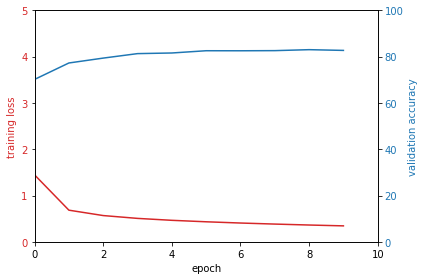

In [0]:
best_model, losses, accs = train_model(model, optimizer, loss_function, train_loader, val_loader, n_epochs)

In [0]:
print(f"Test accuracy: {evaluate_model(model, test_loader)}%")

Test accuracy: 79.715%


In [0]:

model_path = f'lstm_quickdraw.model.{time.time()}'
torch.save(best_model, model_path)

print(f"Model saved at: {model_path}")